# FLIGHT PRICES ANALYSIS

## Scraping, cleaning and exploring

Adioso uses 3 APIs to request flight prices, so I will use them to request flights for every day and every month. I create a python script that takes a month and an airport, and returns a csv file with the prices, flight numbers, airlines and dates. I then concatenate the csv files for each airport to create a big DataFrame for the whole year.

### Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
plt.style.use('fivethirtyeight')
from ipywidgets import *
from IPython.display import display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from tqdm import tqdm
import pandas as pd
from datetime import datetime as dt

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf, acf

### Scraping script, to run in terminal 

### Concatenate and clean scraped DataFrames

#### Concatenator function

In [5]:
def concatenator(airport):
    months = [i for i in range(1, 13) if i not in [9]]
    df = pd.DataFrame()
    for month in months:
        i = pd.read_csv(f'/Users/jacobo/Documents/{airport}_{month}.csv')
        df = pd.concat([df, i])

    # eliminate duplicates, keep the cheaper prices
    df = df.groupby(['flightNo', 'departure', 'airline', 'date'])[
        ['price']].min().reset_index()
    df.sort_values(by='date')
    pd.to_datetime(df.date)

    # creates datetime index by merging date and departure time
    df.index = pd.to_datetime(df.apply(lambda x: x[3]+" "+x[1], axis=1))
    df = df.sort_index()

    # creates 3 new columns, weekday, day of month, and month
    df['fulldate'] = pd.to_datetime(df.index)
    df['weekday'] = df.fulldate.dt.weekday_name
    df['monthday'] = df.fulldate.dt.day
    df['month'] = df.fulldate.dt.strftime("%b")

    # creates 1 new binary feature, 1 if weekend, else 0
    weekend = []
    for weekday in list(df.weekday):
        if weekday in ['Saturday', 'Sunday']:
            weekend.append(1)
        else:
            weekend.append(0)
    df['weekend'] = weekend

    # dummifies the following variables: weekday, monthday and month
    df = pd.concat([df, pd.get_dummies(df.weekday)], axis=1)
    #df = df.drop(columns=['fulldate','weekday'])
    df = pd.concat([df, pd.get_dummies(df.monthday)], axis=1)
    #df = df.drop(columns=['monthday'])
    df = pd.concat([df, pd.get_dummies(df.month)], axis=1)
    #df = df.drop(columns=['month'])

    # remove British Airways flights, because they are duplicated through Iberia
    df = df[df['airline'] != 'BA']
    #  replace airline codes with full names
    df['airline'] = df['airline'].replace(['D8', 'FR', 'IB', 'U2', 'UX'], [
                                          'Norwegian', 'Ryanair', 'Iberia', 'Air Europa', 'Easyjet'])
    #  dummify airlines
    df = pd.concat([df, pd.get_dummies(df.airline)], axis=1)
    #df = df.drop(columns=['airline'])
    
    # add an airport column
    airportlist = []
    for row in df.price:
        airportlist.append(f'{airport}')
    df['airport'] = airportlist

    print(f'{airport} DataFrame created')
    return df

I import the 4 airports that I have previously scraped with my python script.

In [6]:
LGW = concatenator('LGW')

LGW DataFrame created


In [7]:
LHR = concatenator('LHR')

LHR DataFrame created


In [8]:
STN = concatenator('STN')

STN DataFrame created


In [9]:
LTN = concatenator('LTN')

LTN DataFrame created


In [10]:
print(LGW.shape)
LGW.head(3)

(2315, 64)


,flightNo,departure,airline,date,price,fulldate,weekday,monthday,month,weekend,...,Jun,Mar,May,Nov,Oct,Air Europa,Easyjet,Iberia,Norwegian,airport
2018-10-01 07:25:00,U28275,7:25 am,Air Europa,2018-10-01,50,2018-10-01 07:25:00,Monday,1,Oct,0,...,0,0,0,0,1,1,0,0,0,LGW
2018-10-01 10:05:00,D86051,10:05 am,Norwegian,2018-10-01,45,2018-10-01 10:05:00,Monday,1,Oct,0,...,0,0,0,0,1,0,0,0,1,LGW
2018-10-01 10:10:00,UX1014,10:10 am,Easyjet,2018-10-01,41,2018-10-01 10:10:00,Monday,1,Oct,0,...,0,0,0,0,1,0,1,0,0,LGW


In [11]:
LGW.to_csv('/Users/jacobo/Documents/LGW.csv')
LHR.to_csv('/Users/jacobo/Documents/LHR.csv')
LTN.to_csv('/Users/jacobo/Documents/LTN.csv')
STN.to_csv('/Users/jacobo/Documents/STN.csv')

In [12]:
## Here I concatenate the 4 airports into a single DataFrame
df = pd.concat([LGW,LHR,LTN,STN], sort=True)
df = df.sort_index()
df = df.fillna(0)
df.shape

(7036, 65)

In [13]:
df.to_csv('/Users/jacobo/Documents/4airports.csv')

### Exploring data 

#### Price distribution 

Visualizing price distribution for each airport:

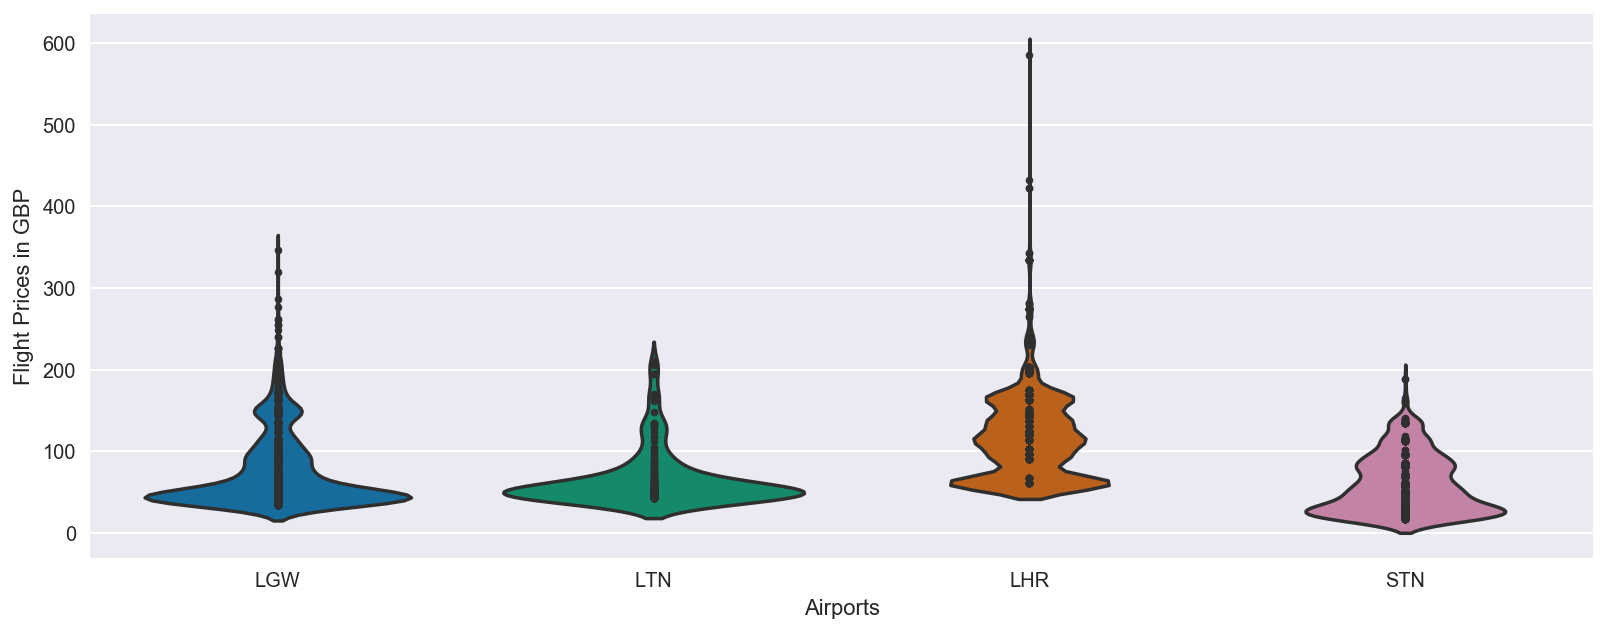

In [14]:
sns.set()
fig, ax = plt.subplots(figsize=(12,5))
sns.violinplot(ax=ax, data=[LGW.price,LTN.price,LHR.price,STN.price], palette='colorblind', inner="points")
ax.set(xlabel='Airports', ylabel='Flight Prices in GBP')
ax.set_xticklabels(['LGW','LTN','LHR','STN'])
plt.show()

#### Cheapest airport?

In [15]:
print('Overall mean price:')
print(df.price.mean())
print('Overall std price:')
print(df.price.std())
print('---------------')
print('LHR mean price:')
print(LHR.price.mean())
print('---------------')
print('LGW mean price:')
print(LGW.price.mean())
print('---------------')
print('LTN mean price:')
print(LTN.price.mean())
print('---------------')
print('STN mean price:')
print(STN.price.mean())

Overall mean price:
90.16785105173393
Overall std price:
51.015466205542836
---------------
LHR mean price:
114.4939430648092
---------------
LGW mean price:
74.29805615550755
---------------
LTN mean price:
65.59358288770053
---------------
STN mean price:
58.51948051948052


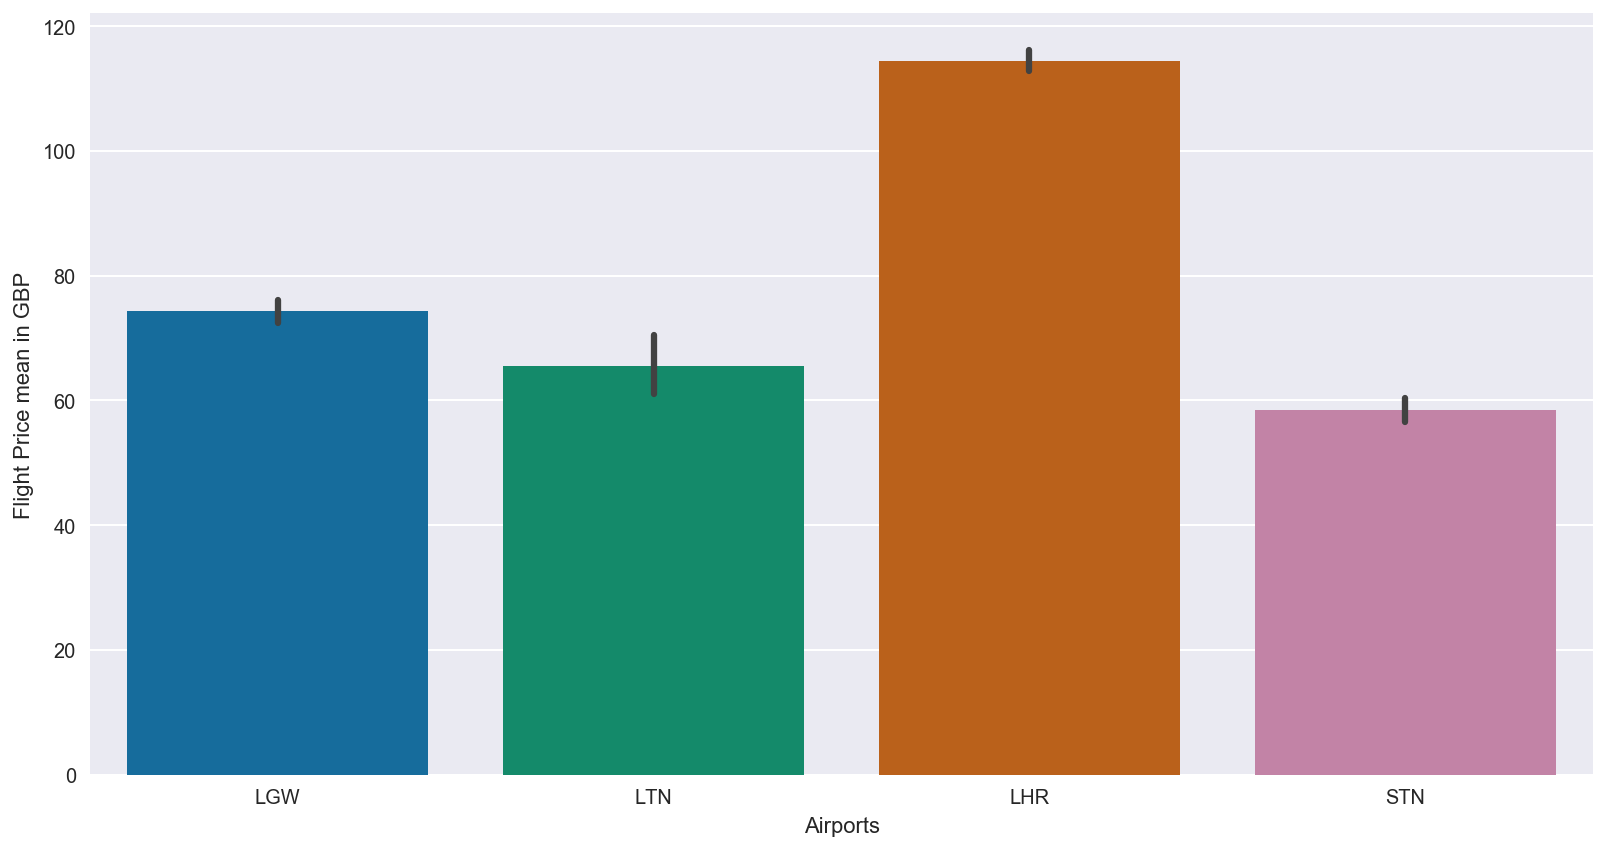

In [16]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(ax=ax, data=[LGW.price,LTN.price,LHR.price,STN.price], palette='colorblind')
ax.set_xticklabels(['LGW','LTN','LHR','STN'])
ax.set(xlabel='Airports', ylabel='Flight Price mean in GBP')
plt.show()

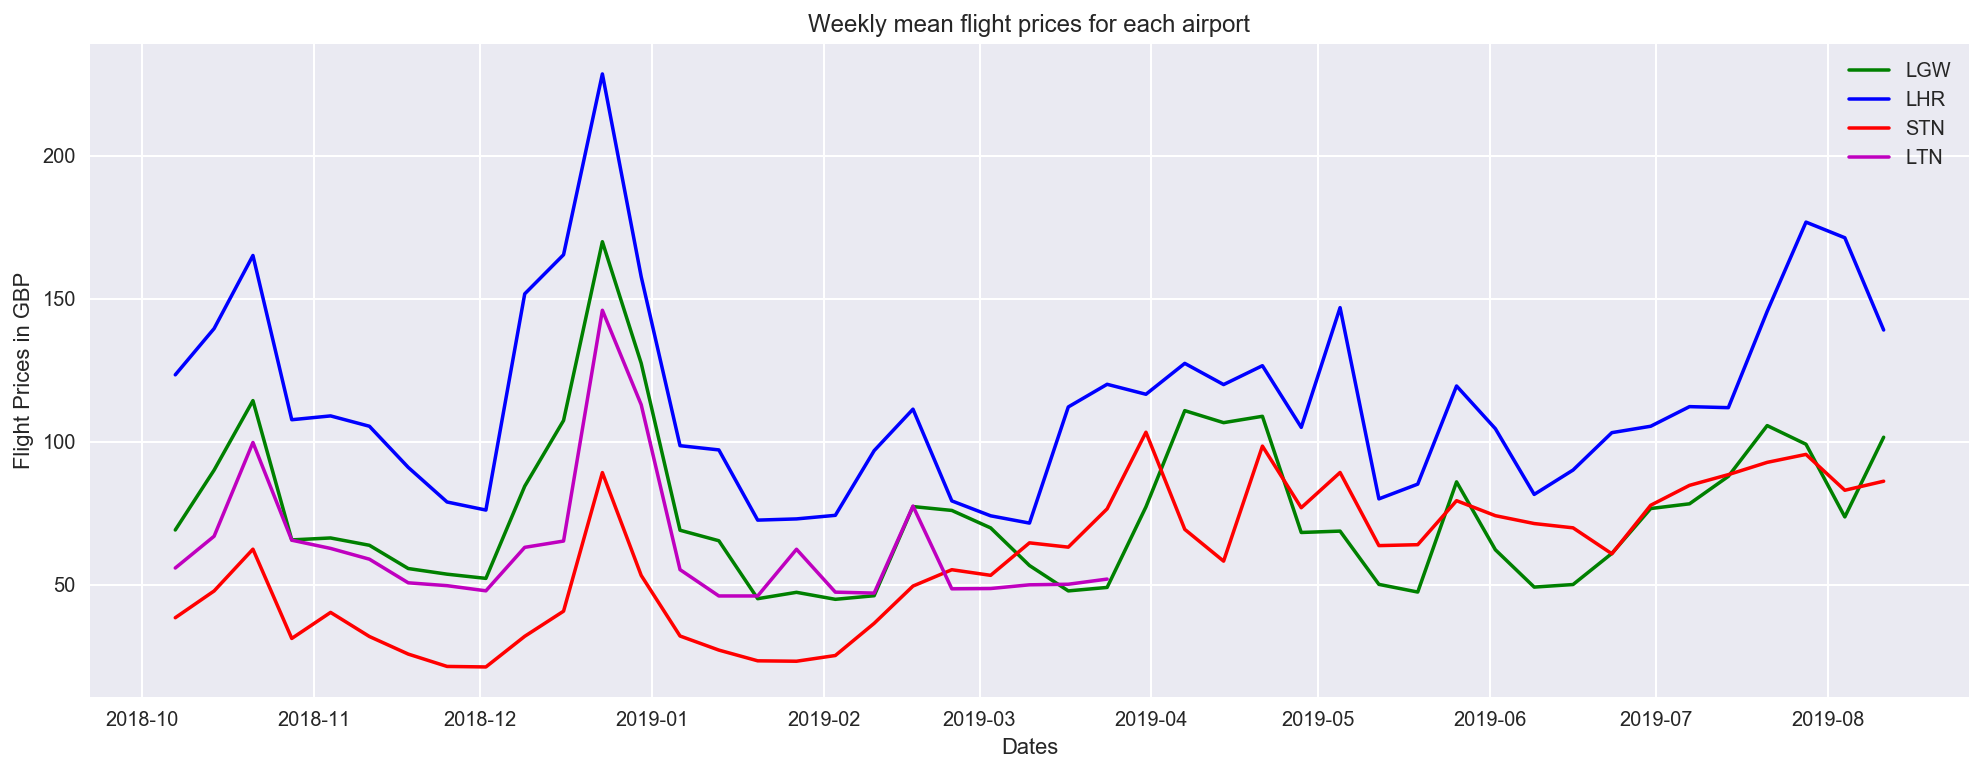

In [17]:
# plotting the 4 airports weekly mean price fluctuations throughout the year
fig, ax = plt.subplots(1, sharey=True, figsize=(15,6))
ax.plot(LGW.price.resample('W').mean(), color='g')
ax.plot(LHR.price.resample('W').mean(), color='b')
ax.plot(STN.price.resample('W').mean(), color='r')
ax.plot(LTN.price.resample('W').mean(), color='m')
ax.legend(('LGW','LHR','STN','LTN'))
ax.set(xlabel='Dates',ylabel = 'Flight Prices in GBP', title='Weekly mean flight prices for each airport')
plt.show()

#### Cheapest day of the month? 

In [18]:
print('LHR cheapest monthday:')
print(LHR.groupby('monthday')['price'].mean().sort_values().head(10))

print('LGW cheapest monthday:')
print(LGW.groupby('monthday')['price'].mean().sort_values().head(10))

print('LTN cheapest monthday:')
print(LTN.groupby('monthday')['price'].mean().sort_values().head(10))

print('STN cheapest monthday:')
print(STN.groupby('monthday')['price'].mean().sort_values().head(10))

print('Overall cheapest monthday:')
print(df.groupby('monthday')['price'].mean().sort_values().head(10))

LHR cheapest monthday:
monthday
2      99.689655
9     100.745283
26    101.694444
10    104.031250
1     105.308333
6     107.373832
27    107.592593
8     107.690909
11    108.376147
7     109.457143
Name: price, dtype: float64
LGW cheapest monthday:
monthday
2     59.253521
1     62.146667
13    62.378378
3     64.560000
6     64.824324
12    66.810127
30    67.343750
31    67.577778
10    68.641026
7     68.775000
Name: price, dtype: float64
LTN cheapest monthday:
monthday
13    47.000000
3     47.857143
6     48.000000
12    48.600000
7     51.000000
1     51.857143
31    53.000000
5     53.000000
8     56.571429
29    57.250000
Name: price, dtype: float64
STN cheapest monthday:
monthday
7     46.575000
13    47.500000
6     48.681818
16    49.300000
31    50.521739
9     51.000000
25    52.277778
12    53.075000
5     53.590909
29    54.666667
Name: price, dtype: float64
Overall cheapest monthday:
monthday
2     78.521186
6     81.021645
10    81.407240
9     82.345133
13    82.3

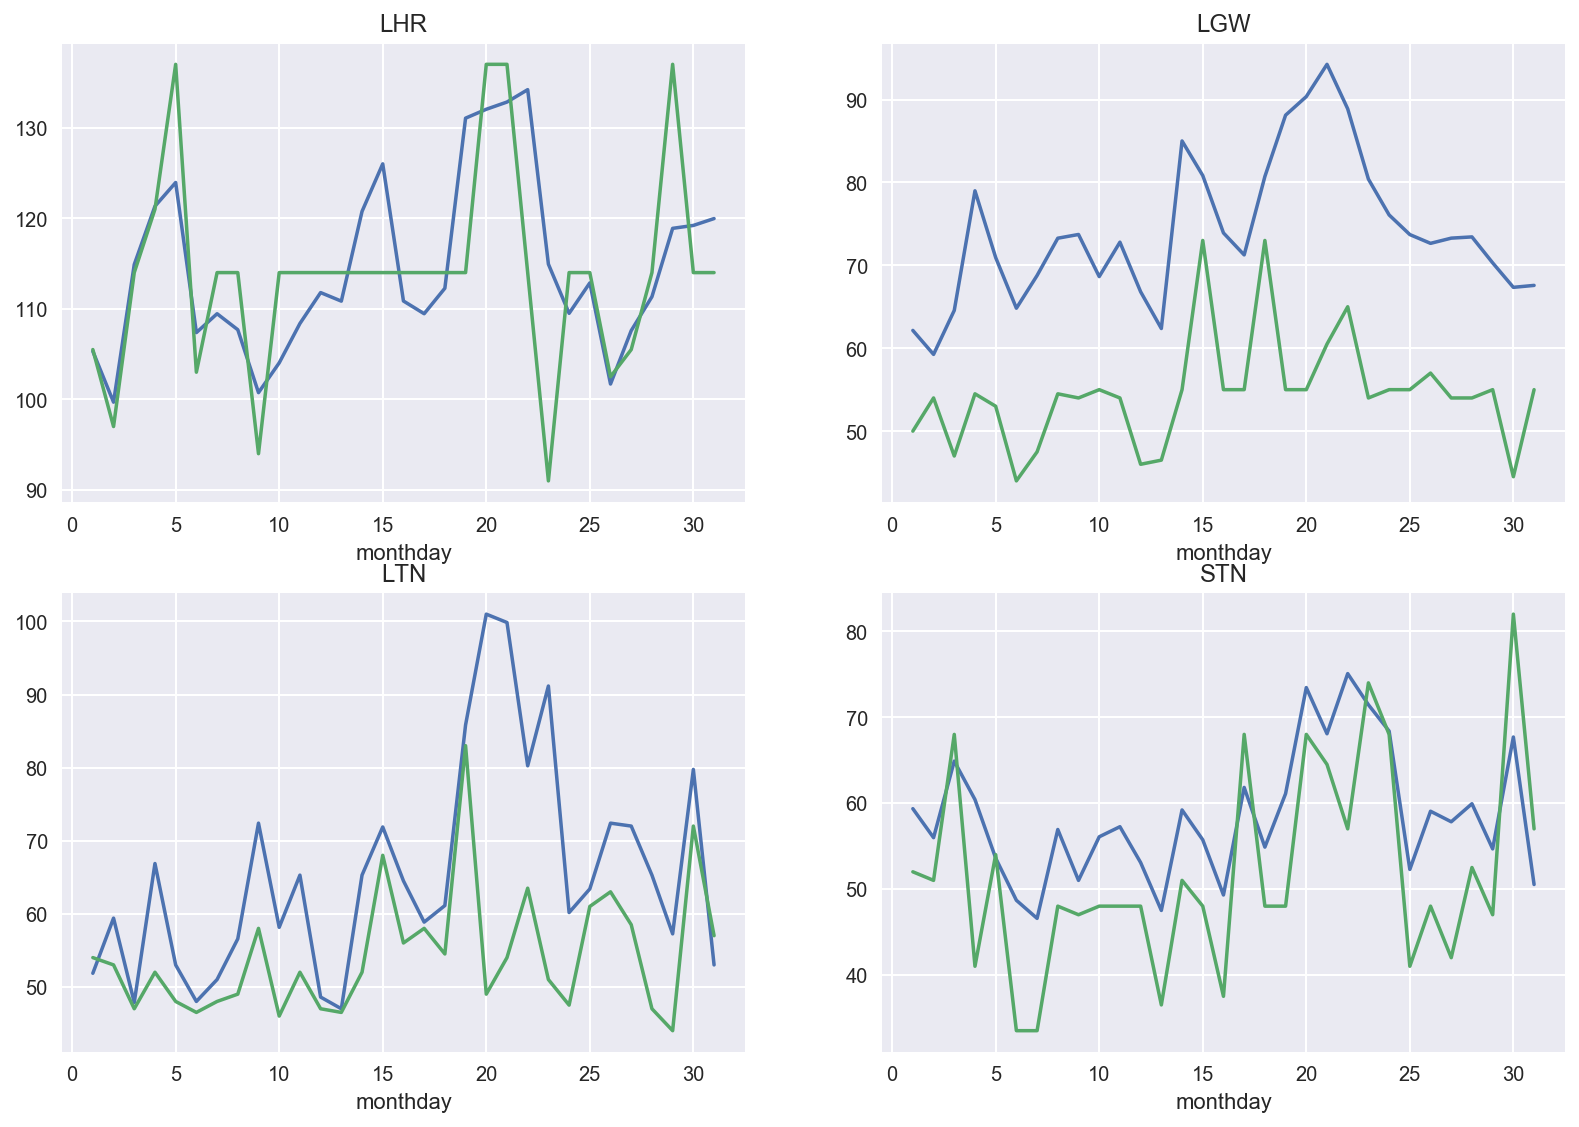

In [19]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,7))
LHR.groupby('monthday')['price'].mean().plot(ax=ax[0][0])
LHR.groupby('monthday')['price'].median().plot(ax=ax[0][0])
LGW.groupby('monthday')['price'].mean().plot(ax=ax[0][1])
LGW.groupby('monthday')['price'].median().plot(ax=ax[0][1])
LTN.groupby('monthday')['price'].mean().plot(ax=ax[1][0])
LTN.groupby('monthday')['price'].median().plot(ax=ax[1][0])
STN.groupby('monthday')['price'].mean().plot(ax=ax[1][1])
STN.groupby('monthday')['price'].median().plot(ax=ax[1][1])
ax[0][0].title.set_text('LHR')
ax[0][1].title.set_text('LGW')
ax[1][0].title.set_text('LTN')
ax[1][1].title.set_text('STN')
plt.subplots_adjust(left=None, bottom=2.2, right=None, top=3.2,
                wspace=None, hspace=None)
plt.show()

In [20]:
df_mean = pd.DataFrame([df.groupby('monthday')['price'].mean()])
df_mean = df_mean.T
df_mean.columns = ['mean']
deviation = []
for monthday in df_mean['mean']:
    deviation.append(float((monthday - df_mean.mean())/df_mean.std()))
df_mean['deviation']=deviation
df_mean.sort_values(by='mean')

,mean,deviation
monthday,,
2,78.521186,-1.456479
6,81.021645,-1.142048
10,81.407240,-1.093560
9,82.345133,-0.975620
13,82.383929,-0.970742
1,82.502041,-0.955889
7,82.823276,-0.915494
26,84.026201,-0.764227
12,85.331915,-0.600034


#### Cheapest day of the week? 

In [21]:
print('LHR cheapest day of the week:')
print(LHR.groupby('weekday')['price'].mean().sort_values())

print('LGW cheapest day of the week:')
print(LGW.groupby('weekday')['price'].mean().sort_values())

print('LTN cheapest day of the week:')
print(LTN.groupby('weekday')['price'].mean().sort_values())

print('STN cheapest day of the week:')
print(STN.groupby('weekday')['price'].mean().sort_values())

LHR cheapest day of the week:
weekday
Tuesday       90.455508
Monday       105.733615
Wednesday    108.642857
Sunday       119.593333
Saturday     120.920668
Thursday     125.437100
Friday       130.579710
Name: price, dtype: float64
LGW cheapest day of the week:
weekday
Tuesday      59.845395
Wednesday    60.915942
Monday       69.811111
Thursday     73.118902
Saturday     78.526132
Friday       83.449153
Sunday       93.762611
Name: price, dtype: float64
LTN cheapest day of the week:
weekday
Tuesday      48.666667
Wednesday    55.578947
Monday       57.846154
Thursday     65.350000
Friday       69.550000
Sunday       76.486486
Saturday     76.764706
Name: price, dtype: float64
STN cheapest day of the week:
weekday
Wednesday    47.234286
Tuesday      47.742857
Monday       52.033708
Thursday     52.318182
Saturday     59.403409
Friday       73.301136
Sunday       77.551136
Name: price, dtype: float64


#### Cheapest month? 

In [22]:
print('LHR cheapest month:')
print(LHR.groupby('month')['price'].mean().sort_values())

print('LGW cheapest month:')
print(LGW.groupby('month')['price'].mean().sort_values())

print('LTN cheapest month:')
print(LTN.groupby('month')['price'].mean().sort_values())

print('STN cheapest month:')
print(STN.groupby('month')['price'].mean().sort_values())

LHR cheapest month:
month
Jan     83.104101
Feb     90.224409
Nov     92.751534
Jun     93.256329
Mar    102.714286
May    109.970674
Apr    118.680251
Oct    130.852041
Jul    138.957055
Aug    158.080645
Dec    168.773163
Name: price, dtype: float64
LGW cheapest month:
month
Jan     54.182796
Mar     57.778626
Jun     58.631579
Nov     60.120623
May     63.773810
Feb     64.959677
Oct     80.879599
Aug     84.250000
Jul     90.751412
Apr     95.824561
Dec    117.346863
Name: price, dtype: float64
LTN cheapest month:
month
Mar    50.714286
Jan    52.157895
Feb    55.296296
Nov    57.280000
Oct    68.878049
Dec    93.775000
Name: price, dtype: float64
STN cheapest month:
month
Jan    25.373984
Nov    29.266667
Oct    42.322581
Feb    43.062500
Dec    51.170940
Jun    70.400000
May    74.290323
Apr    75.066667
Mar    77.483871
Aug    84.291667
Jul    89.564516
Name: price, dtype: float64


In [23]:
LGW_mean = pd.DataFrame([LGW.groupby('month')['price'].mean()])
LGW_mean = LGW_mean.T
LGW_mean.columns = ['mean']
deviation = []
for month in LGW_mean['mean']:
    deviation.append(float((month - LGW_mean.mean())/LGW_mean.std()))
LGW_mean['deviation']=deviation
LGW_mean

,mean,deviation
month,,
Apr,95.824561,1.020216
Aug,84.250000,0.444369
Dec,117.346863,2.090973
Feb,64.959677,-0.515344
Jan,54.182796,-1.051505
Jul,90.751412,0.767821
Jun,58.631579,-0.830174
Mar,57.778626,-0.872609
May,63.773810,-0.574342


#### Some other fancy plots

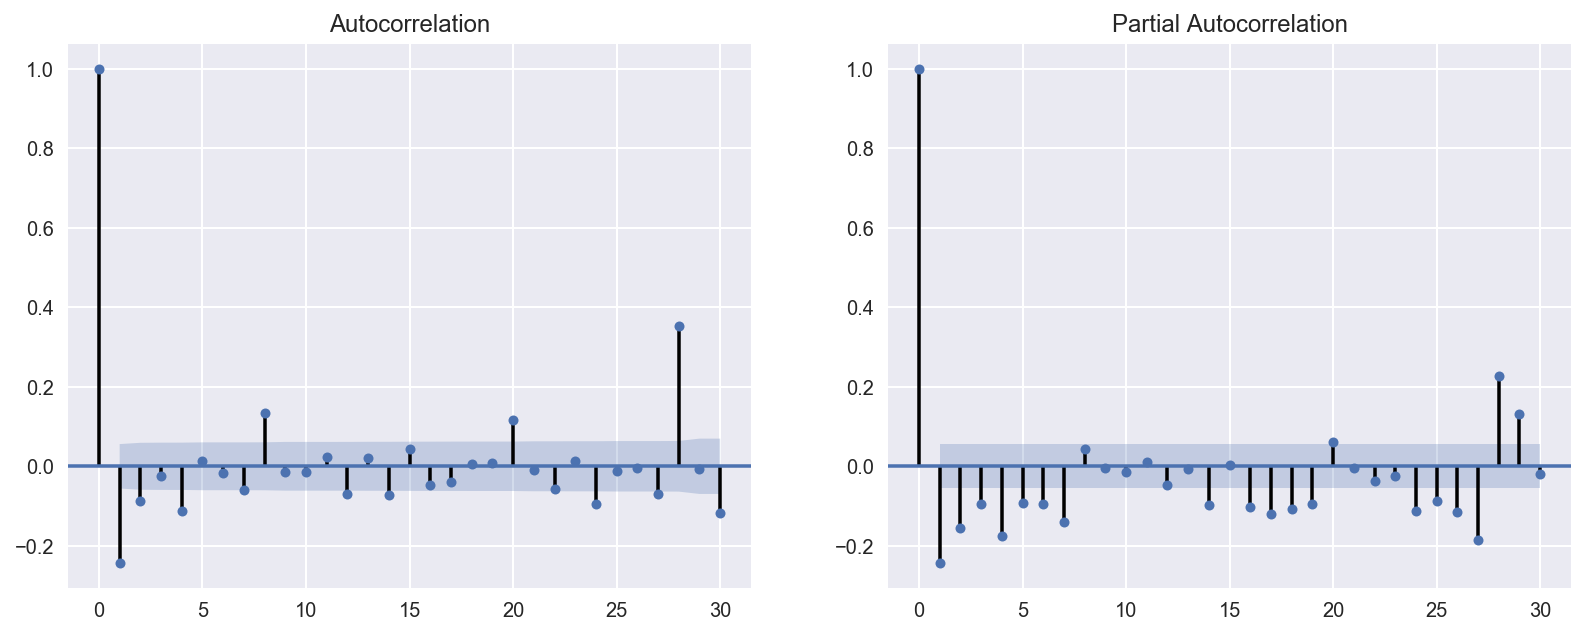

In [24]:
#ACF & PACF plots
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
plot_acf(STN.price.diff()[1:], lags=30, ax=ax[0])
plot_pacf(STN.price.diff()[1:], lags=30, ax=ax[1], method = 'ols')
plt.show()

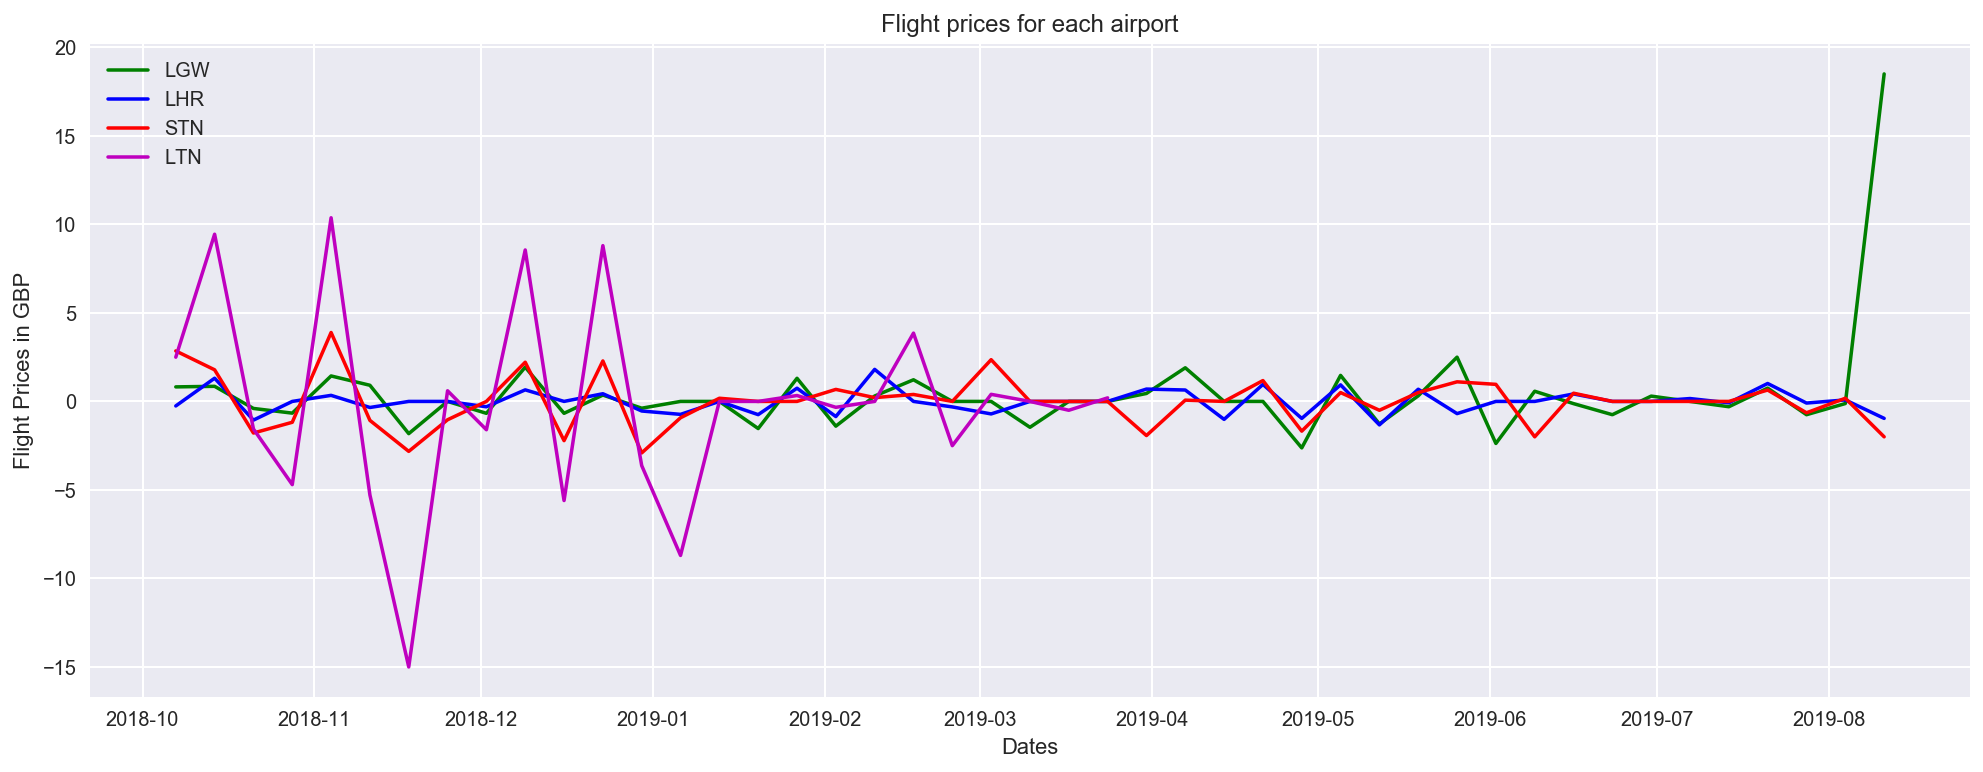

In [25]:
# plotting the 4 airports weekly mean price fluctuations throughout the year
fig, ax = plt.subplots(1, sharey=True, figsize=(15,6))
ax.plot(LGW.price.diff().resample('W').mean(), color='g')
ax.plot(LHR.price.diff().resample('W').mean(), color='b')
ax.plot(STN.price.diff().resample('W').mean(), color='r')
ax.plot(LTN.price.diff().resample('W').mean(), color='m')
ax.legend(('LGW','LHR','STN','LTN'))
ax.set(xlabel='Dates',ylabel = 'Flight Prices in GBP', title='Flight prices for each airport')
plt.show()

## Modelling 

### 1. Predicting the prices for a specific flight number

I pick a specific flight number, and I will try to predict its price based on the prices of previous days.

I will pick flights from LGW because I can use other airlines' prices as predictors.

I want to see if there is a real difference when taking into account the day of the week, day of the month, and month.

#### Airports and flights EDA 

In [26]:
# Checking which airlines fly from which airports, and counting the number of flights with the same number
print('LHR airlines:')
print(list(LHR.airline.unique()))
print('LHR flight numbers:')
print(LHR.flightNo.value_counts())

print('--------------------')
print('LGW airlines:')
print(list(LGW.airline.unique()))
print('LGW flight numbers:')
print(LGW.flightNo.value_counts())

print('--------------------')
print('STN airlines:')
print(list(STN.airline.unique()))
print('STN flight numbers:')
print(STN.flightNo.value_counts())

print('--------------------')
print('LTN airlines:')
print(list(LTN.airline.unique()))
print('LTN flight numbers:')
print(LTN.flightNo.value_counts())

LHR airlines:
['Iberia']
LHR flight numbers:
IB3167    307
IB3177    306
IB3169    304
IB3171    304
IB3175    303
IB3163    299
IB3173    296
IB3179    294
IB7462    259
IB7460    250
IB7458    245
IB7441     27
IB7447     27
IB7449     27
IB7445     27
IB7443     27
Name: flightNo, dtype: int64
--------------------
LGW airlines:
['Air Europa', 'Norwegian', 'Easyjet', 'Iberia']
LGW flight numbers:
UX1014    307
D86055    307
UX1016    307
IB3715    281
IB3717    274
D86051    198
U28277    174
U28283    173
U28281    123
U28279     92
U28275     68
IB3713      7
UX1018      4
Name: flightNo, dtype: int64
--------------------
STN airlines:
['Ryanair']
STN flight numbers:
FR5996    309
FR5994    307
FR5998    307
FR5992    155
FR2682    154
Name: flightNo, dtype: int64
--------------------
LTN airlines:
['Air Europa']
LTN flight numbers:
U22201    79
U22205    56
U22203    52
Name: flightNo, dtype: int64


#### Pick a flight 

In [27]:
LHRIB = LHR.copy()
LHRIB = LHRIB.set_index('date')

In [28]:
LHRIB = LHRIB[LHRIB.flightNo == 'IB3167']

In [29]:
LHRIB['Iberia']=LHR[LHR['flightNo']!='IB3167'].groupby('date')['price'].mean()
#LGWD8['Norwegian']=LGW[LGW['airline']=='Norwegian'].groupby('date')['price'].mean()
#LGWD8['Easyjet']=LGW[LGW['airline']=='Easyjet'].groupby('date')['price'].mean()
#LGWD8['Air Europa']=LGW[LGW['airline']=='Air Europa'].groupby('date')['price'].mean()

In [40]:
#LGWD8['price_shift'] = LGWD8.price.shift(1)
#LGWD8['UX'] = list(LGW[LGW['flightNo'] == 'UX1014'].price)

X = LHRIB.copy()
X = X.drop(columns=['flightNo','departure','airline', 'Iberia', 'airport', 'month', 'monthday', 'weekday', 'fulldate'])
X.dropna(inplace=True)
X.tail(2)

,price,weekend,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,1,...,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct
date,,,,,,,,,,,,,,,,,,,,,
2019-08-06,103,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2019-08-07,131,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


Price will be our target

In [41]:
y = X.pop('price')

In [42]:
X.shape

(307, 50)

Split dataset into train and test

In [43]:
n = 170
X_train, y_train = X[:n], y[:n]
X_test, y_test = X[n:], y[n:]

#### Ridge

In [44]:
#create a hyperparameter dictionary
price_gs_params={'alpha':np.linspace(0,100,500)}

#create a gridsearch object using a model and the dictionary I created above
price_gs=GridSearchCV(Ridge(),
                      price_gs_params,
                      n_jobs=-1,cv=None)

#fit the gridsearch object on the training data
price_gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([  0.    ,   0.2004, ...,  99.7996, 100.    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [45]:
print(price_gs.best_params_)
print('Best score: ')
print(price_gs.best_score_)

{'alpha': 6.012024048096192}
Best score: 
-0.7309033797394084


In [46]:
#assign the best estimator to the variable 'best_linreg'
best_linreg=price_gs.best_estimator_
#score the model on the testing data
best_linreg.score(X_test,y_test)

-0.09730211787508836

#### Linear Regression (simple) 

In [48]:
model = LinearRegression()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6272304638296546
-3.1299867018345917e+28


Now, I try to visualize the predictions and compare them to the real price values:

In [ ]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

X['predictions'] = np.concatenate([predictions_train,predictions_test])

In [ ]:
X['predictions'].plot(figsize=(12,5))
y.plot()
plt.vlines(X.index[n],0,280)
plt.show()

In [ ]:
X['predictions'][n-20:n].plot(figsize=(12,5))
y[n-20:n].plot()
plt.vlines(X.index[n],0,120)
plt.show()

In [ ]:
fig, ax = plt.subplots()
X['predictions'][n:].plot(figsize=(12,5))
y[n:].plot()
plt.vlines(X.index[n],0,280)
ax.legend(('Predictions','Real Prices'))
plt.show()

#### ElasticNet

In [47]:
model = ElasticNet(alpha=1)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.21520169834757139
-0.024199327704711227


#### Lasso

In [49]:
model = Lasso(alpha=2)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.42796606130018805
-0.24890728565905282


Now, I try to visualize the predictions and compare them to the real price values:

In [ ]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

X['predictions'] = np.concatenate([predictions_train,predictions_test])

In [ ]:
X['predictions'].plot(figsize=(12,5))
y.plot()
plt.vlines(X.index[n],0,280)
plt.show()

In [ ]:
X['predictions'][n-20:n].plot(figsize=(12,5))
y[n-20:n].plot()
plt.vlines(X.index[n],0,120)
plt.show()

In [ ]:
fig, ax = plt.subplots()
X['predictions'][n:].plot(figsize=(12,5))
y[n:].plot()
plt.vlines(X.index[n],0,280)
ax.legend(('Predictions','Real Prices'))
plt.show()

#### Random Forest Regressor

In [50]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.928051997514165
-0.6193376033927447


Now, I try to visualize the predictions and compare them to the real price values:

In [ ]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

X['predictions'] = np.concatenate([predictions_train,predictions_test])

In [ ]:
X['predictions'].plot(figsize=(12,5))
y.plot()
plt.vlines(X.index[n],0,280)
plt.show()

In [ ]:
fig, ax = plt.subplots()
X['predictions'][n:].plot(figsize=(12,5))
y[n:].plot()
plt.vlines(X.index[n],0,280)
ax.legend(('Predictions','Real Prices'))
plt.show()

### 2. Fitting a LINEAR REGRESSION model to predict price differences 

Instead of trying to predict the actual price, I took a look at price differences (subtracting today's price from yesterday).

I group by date, and find the minimum price for each airline

In [ ]:
LGW_1 = pd.DataFrame()

LGW_1['Iberia']=LGW[LGW['airline']=='Iberia'].groupby('date')['price'].mean().diff()
LGW_1['Norwegian']=LGW[LGW['airline']=='Norwegian'].groupby('date')['price'].mean().diff()
LGW_1['Easyjet']=LGW[LGW['airline']=='Easyjet'].groupby('date')['price'].mean().diff()
LGW_1['Air Europa']=LGW[LGW['airline']=='Air Europa'].groupby('date')['price'].mean().diff()

I include the day of the week as well:

In [ ]:
LGW_1['Air Europa'].mean()

In [ ]:
fig,ax = plt.subplots(figsize=(12,5))
LGW_1[['Iberia','Norwegian','Easyjet','Air Europa']].diff().plot(ax=ax)
plt.show()

In [ ]:
X = LGW_1.copy()
y = X.pop('Air Europa')
X.dropna(inplace=True)
y = y[1:]
X.head(3)

In [ ]:
X.shape

In [ ]:
## we divide our dataset into part2 (the part in which we have available Air Europa prices, our y),
# and part3 (no Air Europa prices, no y)
y2 = y[:155]
X2 = X[:155]
y3 = y[155:]
X3 = X[155:]

In [ ]:
y2 = y2.fillna(method='ffill')
X2 = X2.fillna(method='ffill')

In [ ]:
n = round((y2.shape[0])*0.30)
X_train, y_train = X2[:n], y2[:n]
X_test, y_test = X2[n:], y2[n:]

In [ ]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
print(model_lr.score(X_train, y_train))
print(model_lr.score(X_test, y_test))

In [ ]:
model = ElasticNet(alpha=800)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

In [ ]:
model_rfr = RandomForestRegressor(n_estimators=100)
model_rfr.fit(X_train, y_train)
print(model_rfr.score(X_train, y_train))
print(model_rfr.score(X_test, y_test))

In [ ]:
X3_lr = list(model_lr.predict(X3))
X3_rfr = list(model_rfr.predict(X3))

In [ ]:
X3['Air Europa lr'] = X3_lr
X3['Air Europa rfr'] = X3_rfr

In [ ]:
fig,ax = plt.subplots(figsize=(12,5))
X3[['Air Europa lr','Air Europa rfr']].plot(ax=ax)
plt.show()

### 3. Fitting a LOGISTIC REGRESSION model to predict if the price will go up or down

Another possibility was to build a model that could predict today's price, taking the prices from the past two days as predictors.

In [ ]:
LGWD8 = LGW[LGW.flightNo == 'D86055']
LGWD8['price_shift_1'] = LGWD8.price.shift(1)
LGWD8['price_shift_2'] = LGWD8.price.shift(2)

#### Linear Regression

In [53]:
X = LGWD8[['price','price_shift_1','price_shift_2']].copy()
X.head()

/Users/jacobo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jacobo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,price,price_shift_1,price_shift_2
2018-10-01 20:20:00,40,NaN,NaN
2018-10-02 20:20:00,35,40.0,NaN
2018-10-03 20:20:00,35,35.0,40.0
2018-10-04 20:20:00,55,35.0,35.0
2018-10-05 20:20:00,75,55.0,35.0


In [54]:
X.dropna(inplace=True)
y = X.pop('price')

In [55]:
X.shape

(305, 2)

In [56]:
n = 100
X_train, y_train = X[:n], y[:n]
X_test, y_test = X[n:], y[n:]

In [57]:
model = LinearRegression()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.3546546897862919
0.6740440902408306


#### Logistic Regression 

In [141]:
X = LGWD8[['price','price_shift_1','price_shift_2']].copy()
X.head()

,price,price_shift_1,price_shift_2
2018-10-01 20:20:00,40,NaN,NaN
2018-10-02 20:20:00,35,40.0,NaN
2018-10-03 20:20:00,35,35.0,40.0
2018-10-04 20:20:00,55,35.0,35.0
2018-10-05 20:20:00,75,55.0,35.0


In [144]:
X['up'] = (X.price.diff(-1)<0)*1

In [145]:
X.dropna(inplace=True)

y = X.pop('up')

In [146]:
X.shape

(305, 3)

In [147]:
# Baseline score
y.value_counts(normalize=True).max()

0.7278688524590164

In [148]:
n = 100
X_train, y_train = X[:n], y[:n]
X_test, y_test = X[n:], y[n:]

In [149]:
model = LogisticRegression()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.69
0.7463414634146341


In [150]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.92
0.5024390243902439


### 4. Predicting prices for one airline (Air Europa) using prices of other airlines

When taking a look at the data from Luton airport, I realized that I had only successfully scraped prices from October up to March. I found out that Air Europa only shows flights for the next 6 months. I took this problem as an opportunity to build a model to predict the cheapest daily price from Air Europa, given the prices from other airlines as predictors.

#### Predicting Air Europa prices for the rest of the year

In [124]:
LGW2 = pd.DataFrame()
LGW2['Iberia']=LGW[LGW['airline'] == 'Iberia'].groupby('date')['price'].min()
LGW2['Air Europa']=LGW[LGW['airline'] == 'Air Europa'].groupby('date')['price'].min()
LGW2['Easyjet']=LGW[LGW['airline'] == 'Easyjet'].groupby('date')['price'].min()
LGW2['Norwegian']=LGW[LGW['airline'] == 'Norwegian'].groupby('date')['price'].min()

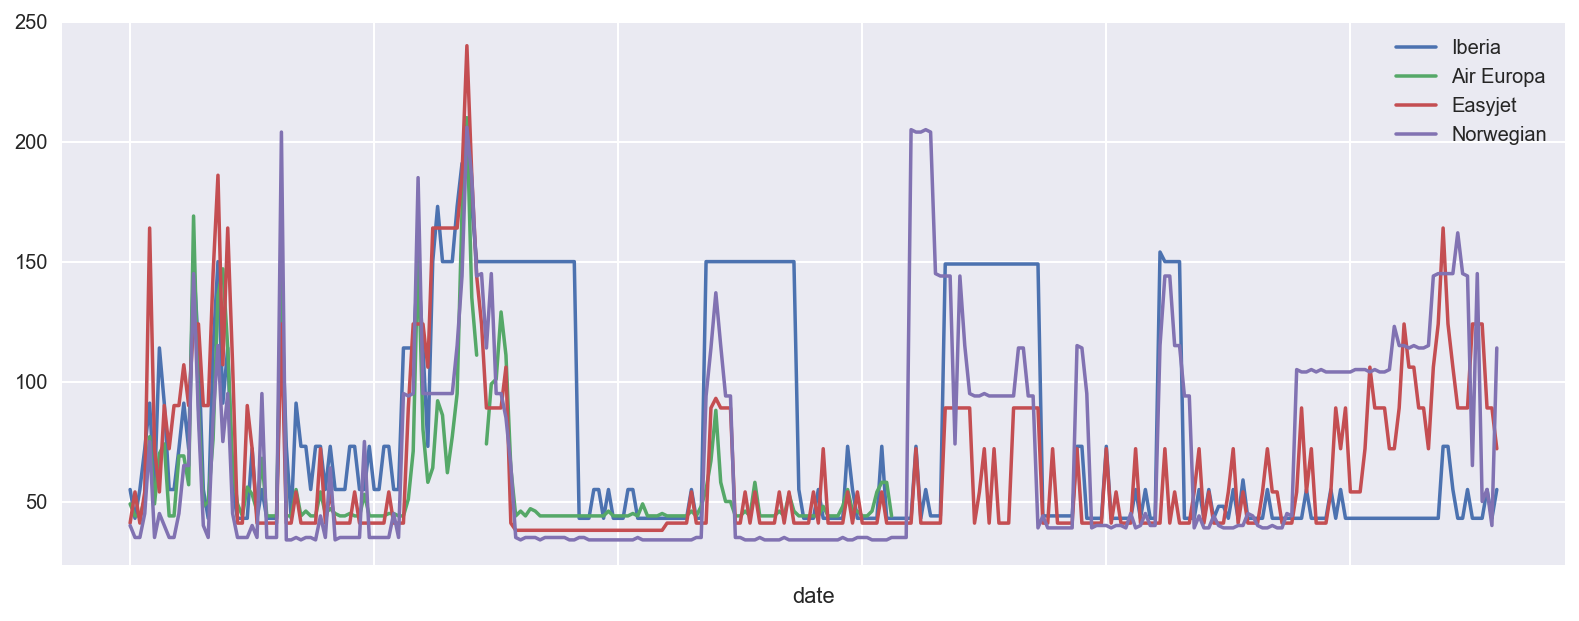

In [125]:
fig,ax = plt.subplots(figsize=(12,5))
LGW2.plot(ax=ax);

In [126]:
LGW2 = LGW2.fillna(method='ffill')
X = LGW2[['Easyjet','Air Europa','Norwegian','Iberia']].copy()
y = X.pop('Air Europa')
X.head(3)

,Easyjet,Norwegian,Iberia
date,,,
2018-10-01,41,40,55
2018-10-02,54,35,43
2018-10-03,41,35,55


In [127]:
# we divide our dataset into part1 (the part in which we have available Air Europa prices, our y),
# and part2 (no Air Europa prices, no y)
y1 = y[:156]
X1 = X[:156]
y2 = y[156:]
X2 = X[156:]

In [128]:
y1.shape[0]

156

In [129]:
n = round((y1.shape[0])*0.4)
X_train, y_train = X1[:n], y1[:n]
X_test, y_test = X1[n:], y1[n:]

In [130]:
model = LinearRegression()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.7672542757469313
0.5943773396799437


#### Ridge 

In [131]:
#create a hyperparameter dictionary
price_gs_params={'alpha':np.linspace(10000,30000,500)}

#create a gridsearch object using a model and the dictionary I created above
price_gs=GridSearchCV(Ridge(),
                      price_gs_params,
                      n_jobs=-1,cv=None)

#fit the gridsearch object on the training data
price_gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([10000.     , 10040.08016, ..., 29959.91984, 30000.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [132]:
print(price_gs.best_params_)
print('Best score: ')
print(price_gs.best_score_)

{'alpha': 17094.188376753507}
Best score: 
0.665524450444512


In [133]:
#assign the best estimator to the variable 'best_linreg'
best_linreg=price_gs.best_estimator_
#score the model on the testing data
best_linreg.score(X_test,y_test)

0.602982945532544

#### Lasso 

In [134]:
#create a hyperparameter dictionary
price_gs_params={'alpha':np.linspace(0,300,500)}

#create a gridsearch object using a model and the dictionary I created above
price_gs=GridSearchCV(Lasso(),
                      price_gs_params,
                      n_jobs=-1,cv=None)

#fit the gridsearch object on the training data
price_gs.fit(X_train, y_train)

/Users/jacobo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/jacobo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/jacobo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jacobo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fi

GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([  0.    ,   0.6012, ..., 299.3988, 300.    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [135]:
print(price_gs.best_params_)
print('Best score: ')
print(price_gs.best_score_)

{'alpha': 22.845691382765533}
Best score: 
0.6260881140484554


In [136]:
#assign the best estimator to the variable 'best_linreg'
best_linreg=price_gs.best_estimator_
#score the model on the testing data
best_linreg.score(X_test,y_test)

0.6398329094691264

In [137]:
model = Lasso(alpha=300)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.667790139652598
0.7482257293275905


In [138]:
X2_prediction = list(model.predict(X2))

In [139]:
X2['Air Europa prediction'] = X2_prediction

/Users/jacobo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


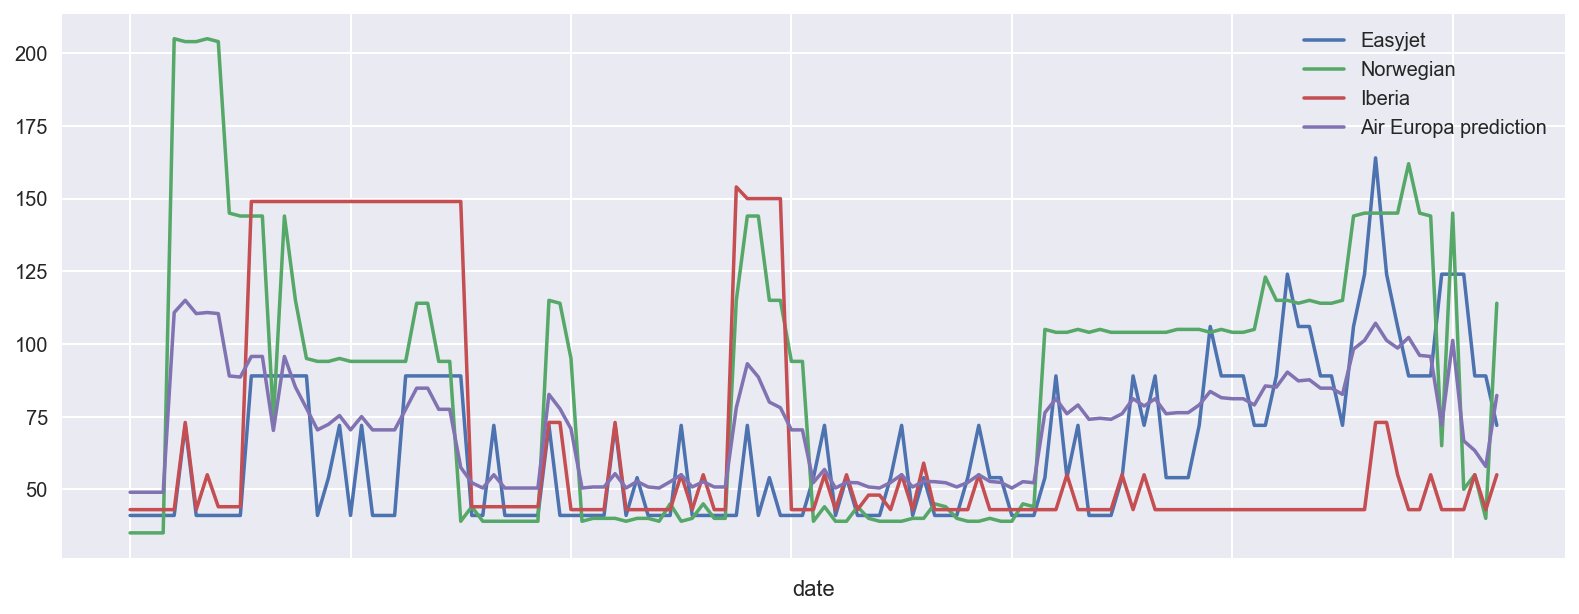

In [140]:
X2.plot(figsize=(12,5))
plt.show()

Back to the presentation...

In [84]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9519917325688363
0.2525720104320085


## Next Steps

#### ARIMA 

In [ ]:
from statsmodels.tsa.arima_model import ARIMA, ARMA, AR

In [ ]:
model = ARIMA(y,order=(1,1,1)).fit(trend='c')


In [ ]:
model.summary2()

In [ ]:
from statsmodels.tsa import stattools

auto_select = stattools.arma_order_select_ic(
    y, max_ar=4, max_ma=4, ic=['aic', 'bic'], trend='nc')

print(auto_select)

sns.heatmap(auto_select['aic'], annot=True, fmt='.1f')
plt.title('AIC auto select')
plt.show()

sns.heatmap(auto_select['bic'], annot=True, fmt='.1f')
plt.title('BIC auto select')
plt.show()

In [ ]:
model = ARMA(y,order=(2,3))
result = model.fit(start_params=[0,0,0,0,0],solver='lbfgs',method='css',trend='nc',ic='BIC')
# without setting start_params it might not succeed in finding the MLE
# requires as many start_params as model parameters, i.e. p+q
result.summary2()

In [ ]:
init_1 = 2
end_1 = len(y)+50
fig, ax = plt.subplots(figsize=(12,8))
result.plot_predict(init_1,end_1,dynamic=False,plot_insample=True,ax=ax)
ax.set_title('In-sample predictions and out-of-sample forecasts',fontsize=24)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, sharey=True)
ax.plot(LGW.resample('W').median().diff())
ax.plot(LGW.resample('W').mean().diff())


#### Seasonal decomposing 

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
result = seasonal_decompose(STN.resample('W').median(), freq=7)
result.plot();

In [ ]:
LGW_mean = pd.DataFrame([LGW.groupby('date')['price'].mean(), LGW.groupby('date')['price'].std()])

LGW_mean = LGW_mean.T

LGW_mean.columns = ['mean', 'std']

LGW_mean.shape

In [ ]:
LGW.groupby('flightNo').count().plot(kind='bar', figsize=(15,6));

In [ ]:
LGW.groupby(['date', 'flightNo'])[['price']].min().head()

Mean and standard deviation for each date:

In [ ]:
LGW_dev = LGW_mean.copy()
for flight in list(LGW['flightNo'].unique()):
    LGW_dev[f'{flight}']=(LGW[LGW['flightNo'] == f'{flight}'].sort_values('date').groupby('date')['price'].min() - LGW_mean['mean'])/LGW_mean['std']
    

LGW_dev = LGW_dev.drop(columns=['mean','std'])

In [ ]:
LGW_dev.plot(kind='hist', bins=25, colormap=('Accent'), figsize=(15,7), stacked=True);

In [ ]:
LGW_dev.plot(figsize=(15,7), colormap='Accent');

In [ ]:
LGW_dev[LGW_dev['UX1014'] < -1.5]

### Airlines scores

In [ ]:
airlines = pd.read_csv('../Documents/airlines.csv')

In [ ]:
print(airlines.shape)
airlines.head()

In [ ]:
airlines = airlines[(airlines['Airline'] == 'Easyjet')|(airlines['Airline'] == 'Norwegian')|(airlines['Airline'] == 'Iberia')|(airlines['Airline'] == 'Ryanair')|(airlines['Airline'] == 'Air Europa')]

In [ ]:
print(airlines.shape)
airlines.head()

### Mean and Standard Deviation for each date 

In [ ]:
LGW_mean = pd.DataFrame([LGW.groupby('date')['price'].mean(), LGW.groupby('date')['price'].std()])
LGW_mean = LGW_mean.T
LGW_mean.columns = ['mean', 'std']
LGW_mean.shape

The DataFrame lhr_dev will  contain the price for every flightNo, normalized with the mean and std of each day.

In [ ]:
LGW_dev = LGW_mean.copy()
for airl in list(LGW['airline'].unique()):
    LGW_dev[f'{airl}']=(LGW[LGW['airline'] == f'{airl}'].sort_values('date').groupby('date')['price'].min() - LGW_mean['mean'])/LGW_mean['std']

In [ ]:
LGW_dev = LGW_dev.drop(columns=['mean','std'])

The flight prices that we consider to be DEALS are located 2 standard deviations below than the mean.

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2)
LGW_dev.Easyjet.plot(kind='hist', figsize=(15,7), alpha=1, ax=ax[0][0])
LGW_dev.Norwegian.plot(kind='hist', figsize=(15,7), alpha=1, ax=ax[0][1]);
LGW_dev.Iberia.plot(kind='hist', figsize=(15,7), alpha=1, ax=ax[1][0]);
LGW_dev['Air Europa'].plot(kind='hist', figsize=(15,7), alpha=1, ax=ax[1][1]);